# Zillow Average Home Price Prediction 

Exploring a variety of time series models using Zillow average home price data from Kaggle.


In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm

from math import sqrt
from numpy import concatenate

from statsmodels.graphics.tsaplots       import plot_acf
from statsmodels.graphics.tsaplots       import plot_pacf
from statsmodels.tsa.stattools           import adfuller
from statsmodels.tsa.holtwinters         import ExponentialSmoothing
from statsmodels.tsa.statespace.sarimax  import SARIMAX

from pmdarima.arima                      import auto_arima

from sklearn.metrics                     import mean_squared_error
from sklearn.preprocessing               import MinMaxScaler
from sklearn.metrics                     import mean_squared_error

from fbprophet import Prophet

import warnings
warnings.filterwarnings("ignore")

# Part 1: EDA 

### Reading in the data 

In [ ]:
data = pd.read_csv('zillow-carlifornia.csv')

In [ ]:
data.tail()

,Date,MedianSoldPrice_AllHomes.California,MedianMortageRate,UnemploymentRate
102,2016-08-31,NaN,3.46,4.8
103,2016-09-30,NaN,3.42,5.0
104,2016-10-31,NaN,3.36,5.0
105,2016-11-30,NaN,3.47,4.8
106,2016-12-31,NaN,4.07,4.7


### Initial Exploration

In [ ]:
history = data.loc[data['Date']<='2015-12-31']
test = data.loc[data['Date']>'2015-12-31']

In [ ]:
plt_history = history
plt_history["Date"] = pd.to_datetime(plt_history["Date"])

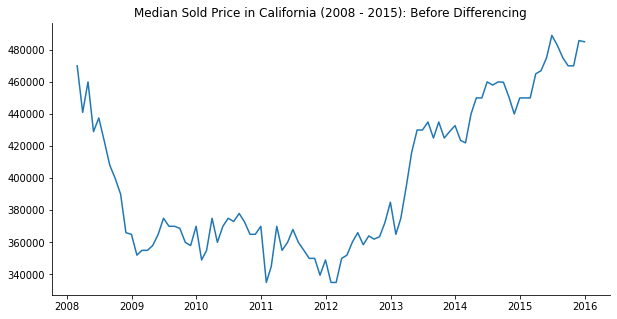

In [ ]:
fig, ax = plt.subplots(figsize=(10,5))

plt.plot(plt_history['Date'], plt_history['MedianSoldPrice_AllHomes.California'])

ax.set_title("Median Sold Price in California (2008 - 2015): Before Differencing")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.show()

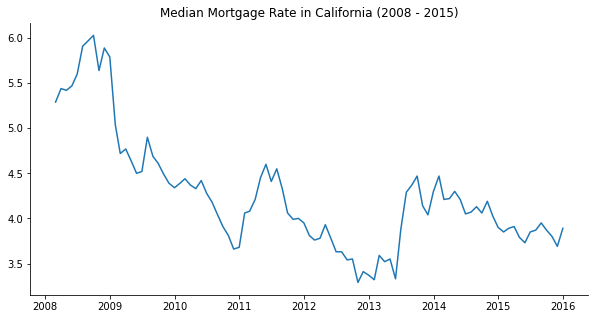

In [ ]:
fig, ax = plt.subplots(figsize=(10,5))

plt.plot(plt_history['Date'], plt_history['MedianMortageRate'],)

ax.set_title("Median Mortgage Rate in California (2008 - 2015)")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.show()

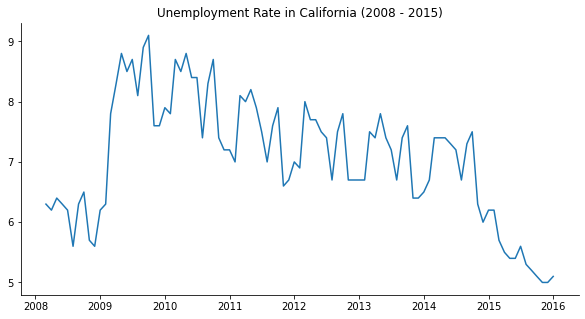

In [ ]:
fig, ax = plt.subplots(figsize=(10,5))

plt.plot(plt_history['Date'], plt_history['UnemploymentRate'],)

ax.set_title("Unemployment Rate in California (2008 - 2015)")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.show()

### Missing Value Imputation

In [ ]:
# median sold price 
price = history[['Date', 'MedianSoldPrice_AllHomes.California']].set_index('Date')['MedianSoldPrice_AllHomes.California']

In [ ]:
history = history.dropna()

In [ ]:
price.isnull().sum(), len(price)

(0, 95)

In [ ]:
# get rid of nan value
new_price = price[price.isnull() == False]
new_price.isnull().sum()

0

### AD Fuller Test

The series fails the ADfuller test, suggesting that it is not stationary. 

In [ ]:
dftest = adfuller(new_price)
dfoutput = pd.Series(dftest[0:2], index=['Test Statistic','p-value'])
print (dfoutput)

Test Statistic   -0.058792
p-value           0.953391
dtype: float64


### ACF & PACF plots 

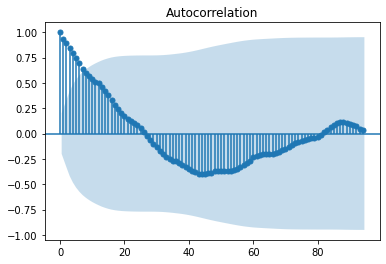

In [ ]:
# larger lags - see the general trend
plot_acf(new_price,lags=94) 

plt.show()

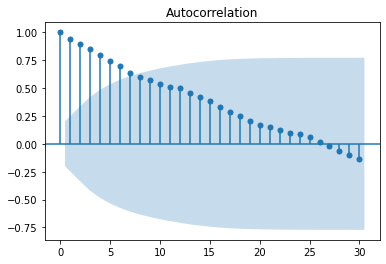

In [ ]:
# smaller lags - zoom in to see the seasonality
plot_acf(new_price,lags=30) 
plt.show()

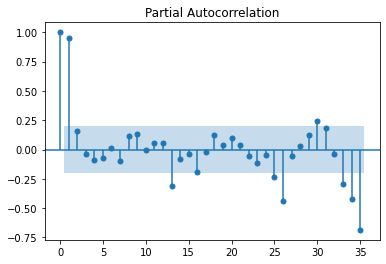

In [ ]:
plot_pacf(new_price,lags=35) 
plt.show()

### Differencing d=2 

In [ ]:
def diff(data, interval=1):
    diff = list()
    for i in range(interval, len(data)):
        value = data[i] - data[i - interval]
        diff.append(value)
    return diff

In [ ]:
# detrend
# looks like it's in shape of a quadratic function
d2 = diff(new_price, 2)

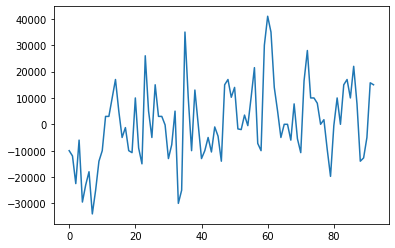

In [ ]:
plt.plot(d2)
plt.show()

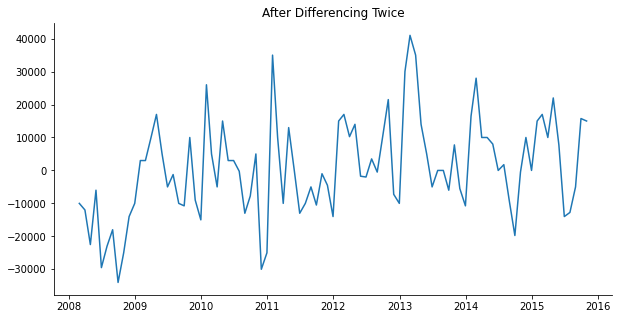

In [ ]:
d2_history = plt_history.drop([94,93])
d2_history['d2'] = d2

fig, ax = plt.subplots(figsize=(10,5))

ax.set_title("After Differencing Twice")

plt.plot(d2_history['Date'], d2_history['d2'])

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.show()


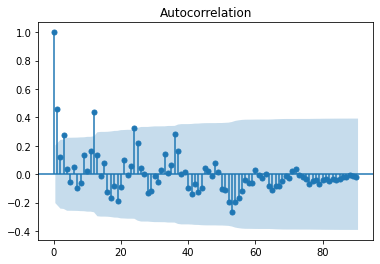

In [ ]:
# larger lags - see the general trend
plot_acf(d2,lags=90) 
plt.show()

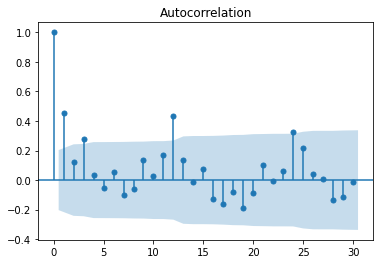

In [ ]:
# smaller lags - zoom in to see the seasonality
# looks like there's a pattern repeating every 12/13 months (yearly)
plot_acf(d2,lags=30) 
plt.show()

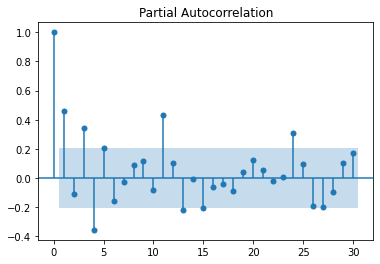

In [ ]:
plot_pacf(d2,lags=30) 
plt.show()

In [ ]:
# stationary after differencing. now d = 2
dftest = adfuller(d2)
dfoutput = pd.Series(dftest[0:2], index=['Test Statistic','p-value'])
print (dfoutput)

Test Statistic   -3.374527
p-value           0.011859
dtype: float64


# Part 2: Candidate Models 

### Candidate 1: ARIMA(0,2,1) from BIC

In [ ]:
from statsmodels.tsa.stattools import arma_order_select_ic
arma_order_select_ic(d2,max_ar=4, max_ma=4, ic='bic')

{'bic':              0            1            2            3            4
 0  2058.976467  2018.274484  2021.748940  2024.332590  2022.787571
 1  2041.645265  2021.601274  2029.046346  2026.473520  2029.023613
 2  2045.230711  2026.054722  2037.541296  2025.922248  2027.405269
 3  2038.557227  2021.044840          NaN          NaN          NaN
 4  2031.617309  2025.067473  2032.732071          NaN  2053.380600,
 'bic_min_order': (0, 1)}

In [ ]:
rmse_sarima(new_price, (0,2,1), (0,0,0,0), 0.8)

10323.72428355811

In [ ]:
split_size = 0.8
def plot_res(X, trend_order, seasonal_order, split_size): #added split_size
    train_size = int(len(X) * split_size)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    predictions = list()
    for t in range(len(test)):
        model = sm.tsa.statespace.SARIMAX(history, order=trend_order,seasonal_order=seasonal_order)
        res = model.fit()
        yhat = res.predict(start=len(history), end=len(history)) #predict one step
        predictions.append(yhat) #store prediction
        history.append(test[t]) #store observation
        # calculate out of sample error
    plt.plot(test,label='Actural prices')
    plt.plot(predictions,label='Predicted prices')
    plt.show()

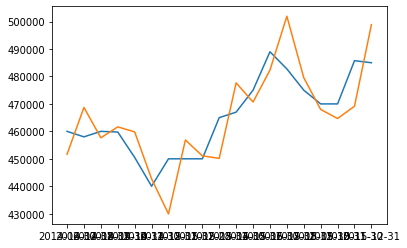

In [ ]:
plot_res(new_price, (0,2,1), (0,0,0,0), 0.8)

### Candidate 2: ARIMA(3,2,1) from AIC

In [ ]:
arma_order_select_ic(d2,max_ar=4, max_ma=4, ic='aic')

{'aic':              0            1            2            3            4
 0  2053.911268  2010.676711  2011.621299  2011.669615  2007.592005
 1  2034.047505  2011.470878          NaN  2011.277155  2011.295193
 2  2035.100349  2013.391575  2022.249469  2008.194080  2007.144465
 3  2025.895165  2005.849243  2010.037619          NaN          NaN
 4  2016.421452  2007.339276  2012.498548          NaN  2027.895818,
 'aic_min_order': (3, 1)}

In [ ]:
rmse_sarima(new_price, (3,2,1), (0,0,0,0), 0.8)

10659.712825971683

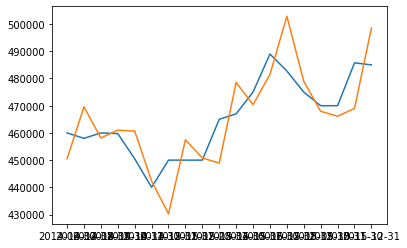

In [ ]:
plot_res(new_price, (3,2,1), (0,0,0,0), 0.8)

### Candidate 3: SARIMA(0, 2, 1), (3, 1, 0, 12) from grid search

In [ ]:
def rmse_sarima(X, trend_order, seasonal_order, split_size): #added split_size
    train_size = int(len(X) * split_size)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    predictions = list()
    for t in range(len(test)):
        model = sm.tsa.statespace.SARIMAX(history, order=trend_order,seasonal_order=seasonal_order)
        res = model.fit()
        yhat = res.predict(start=len(history), end=len(history)) #predict one step
        predictions.append(yhat) #store prediction
        history.append(test[t]) #store observation
        # calculate out of sample error
    rmse = sqrt(mean_squared_error(test, predictions))
    return rmse

def evaluate_rmse_sarima(data, p_values,d_values,q_values,P_values,Q_values,m, D=1):
    best_score, best_order, best_seasonal_order = float("inf"), None, None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                    for P in P_values:
                            for Q in Q_values:
                                order=(p,d,q)
                                seasonal_order=(P,D,Q,m)
                                try:
                                    rmse=rmse_sarima(data,trend_order=order, seasonal_order=seasonal_order, split_size=0.8)                                
                                    if best_score is None or rmse < best_score:
                                        best_score, best_order, best_seasonal_order=rmse, order,seasonal_order
                                except:
                                    continue

    print((best_score, best_order, best_seasonal_order))

In [ ]:
# takes a looooong time to run
p_values = [0,1,2,3]
q_values = [0,1,2,3]
d_values=[2]
m = 12
Q_values=[0,1,2,3]
P_values=[0,1,2,3]
evaluate_rmse_sarima(new_price, p_values,d_values,q_values,P_values,Q_values,m, D=1)

(9522.790671931016, (0, 2, 1), (3, 1, 0, 12))


### Candidate 4: trend: None, seasonality: additive from ETS

In [ ]:
def evaluate_ETS(X, Trend, Seasonal, m, dampen=True):
    if Trend is None:
        dampen = False
    train_size = int(len(X)*0.8)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    predictions = list()
    for t in range(len(test)):
        model = ExponentialSmoothing(history, trend=Trend,seasonal=Seasonal,seasonal_periods=m, damped=dampen)
        res = model.fit()
        yhat = res.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
    rmse = sqrt(mean_squared_error(test, predictions))
    return rmse

def search_param(data, trends, seasonality, m):
    curMin = None
    curMin_param = (None, None)
    for trend in trends:
        for season in seasonality:
            rmse = evaluate_ETS(data, trend, season, m)
            print(trend, season, rmse)
            if curMin is None or rmse < curMin:
                curMin = rmse
                curMin_param = (trend, season)

    print('lowest rmse:', curMin, 'trend:', curMin_param[0], 'seasonality:', curMin_param[1] )

In [ ]:
m = 12
trends = [None, 'mul', 'add']
seasonality = ['add', 'mul']
search_param(new_price, trends, seasonality, m)

None add 10385.301142457125
None mul 10759.152129921094
mul add 2.676292693520865e+53
mul mul 10417.362449996284
add add 11234.07280467184
add mul 11052.810060011167
lowest rmse: 10385.301142457125 trend: None seasonality: add


In [ ]:
def plot_res_ets(X, Trend, Seasonal, m, dampen=True): #added split_size
    train_size = int(len(X) * 0.8)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    predictions = list()
    for t in range(len(test)):
        model = ExponentialSmoothing(history, trend=Trend,seasonal=Seasonal,seasonal_periods=m, damped=dampen)
        res = model.fit()
        yhat = res.predict(start=len(history), end=len(history)) #predict one step
        predictions.append(yhat) #store prediction
        history.append(test[t]) #store observation
        # calculate out of sample error
    plt.plot(test,label='Actural prices')
    plt.plot(predictions,label='Predicted prices')
    plt.show()

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


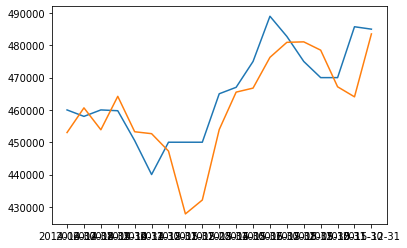

In [ ]:
warnings.filterwarnings("ignore")

plot_res_ets(new_price, None, 'add', 12, dampen=False)

### Candidate 5: Prophet
yearly additive seasonality
RMSE = 37380.18

In [ ]:
prophet_df = pd.DataFrame(new_price).reset_index().rename(columns={"Date": "ds", "MedianSoldPrice_AllHomes.California": "y"})

In [ ]:
#add holidays and weekly seasonality
import holidays
holiday = pd.DataFrame([])
for date, name in sorted(holidays.UnitedStates(years=[2018,2019,2020]).items()):
    holiday = holiday.append(pd.DataFrame({'ds': date, 'holiday': "US-Holidays"}, index=[0]), ignore_index=True)
holiday['ds'] = pd.to_datetime(holiday['ds'], format='%Y-%m-%d', errors='ignore')

In [ ]:
train_size = int(len(prophet_df)*0.8)
train, validation = prophet_df.iloc[0:train_size,:], prophet_df.iloc[train_size:,:]

In [ ]:
validation_dates = validation['ds']

In [ ]:
m = Prophet(holidays=holiday,
            yearly_seasonality=True, 
            seasonality_mode='additive', 
            weekly_seasonality=False, 
            daily_seasonality=False)
m.add_seasonality(name='yearly', period=12, fourier_order=5)
model = m.fit(train)

In [ ]:
future = m.make_future_dataframe(periods=validation.shape[0], freq='M')
forecast = m.predict(future)

In [ ]:
validation['ds'] = pd.to_datetime(validation['ds'])
train['ds'] = pd.to_datetime(train['ds'])

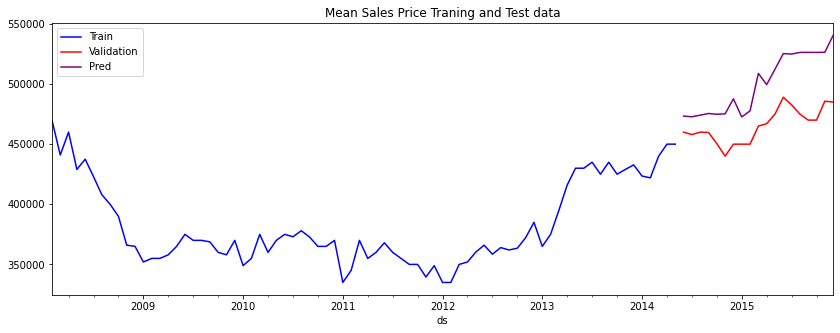

In [ ]:
pred = forecast[['ds', "yhat"]].tail(len(validation))

pd.plotting.register_matplotlib_converters()
f, ax = plt.subplots(figsize=(14,5))

train.plot(kind='line', x='ds', y='y', color='blue', label='Train', ax=ax)
validation.plot(kind='line', x='ds', y='y', color='red', label='Validation', ax=ax)
pred.plot(kind='line', x='ds', y='yhat', color='purple', label='Pred', ax=ax)
plt.title('Mean Sales Price Traning and Test data')

plt.show()

In [ ]:
rmse = sqrt(mean_squared_error(validation['y'], pred['yhat']))
rmse

37380.181570602326

### Candidate 6:  SARIMAX Model - Median Mortgage Rate as Exogenous 

In [ ]:
history_sarimax = history[['Date', 'MedianSoldPrice_AllHomes.California','MedianMortageRate','UnemploymentRate']]

In [ ]:
history_sarimax = history_sarimax[['MedianSoldPrice_AllHomes.California','MedianMortageRate','UnemploymentRate']]
history_sarimax.columns = ['MedianSoldPrice', 'MedianMortgageRate', 'UnemploymentRate']
history_sarimax = history_sarimax[['MedianMortgageRate', 'MedianSoldPrice']]

In [ ]:
train_size = int(len(history_sarimax) * 0.8)
train, validation = history_sarimax[0:train_size], history_sarimax[train_size:]

#scale data
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range=(0, 1))

train_sc = sc.fit_transform(train)
validation_sc = sc.transform(validation)

In [ ]:
#auto sarimax search with m=12
from pmdarima.arima import auto_arima
model=auto_arima(train_sc[:,-1], # MedianSoldPrice as endogenous
                 exogenous= train_sc[:,:-1], # MedianMortgage as exogenous variable
                 start_p=0, start_q=0, 
                 max_p=4, max_q=4, 
                 max_d=2,
                 trace=True,seasonal=True,D=1,m=12, max_P=3, max_Q=3, #add seasonality
                 error_action='ignore', 
                 suppress_warnings=True,information_criterion='oob', n_jobs = -1)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=-125.733, Time=0.18 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=-129.606, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=-128.943, Time=0.16 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=-127.712, Time=0.22 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=-127.831, Time=0.23 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=-127.880, Time=0.16 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=-129.683, Time=0.06 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=-129.248, Time=0.19 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=-126.009, Time=0.21 sec
 ARIMA(2,1,0)(0,1,0)[12]             : AIC=-131.806, Time=0.14 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=-132.717, Time=0.41 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=-131.023, Time=0.63 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=-130.844, Time=0.42 sec
 ARIMA(2,1,0)(0,1,1)[12]             : AIC=-133.358, Time=0.32 sec
 ARIMA(2,1,0)(0,1,2

In [ ]:
y_pred = model.predict(n_periods=len(validation_sc),X=validation_sc[:,:-1]).reshape(-1,1)
y_pred_ = np.repeat(y_pred,2,axis=1) # duplicate the pred column x3 times to fit the scaler's shape
y_pred_inv = sc.inverse_transform(y_pred_)[:,-1] # inverset he duplicated y_pred and get the last colomn as result

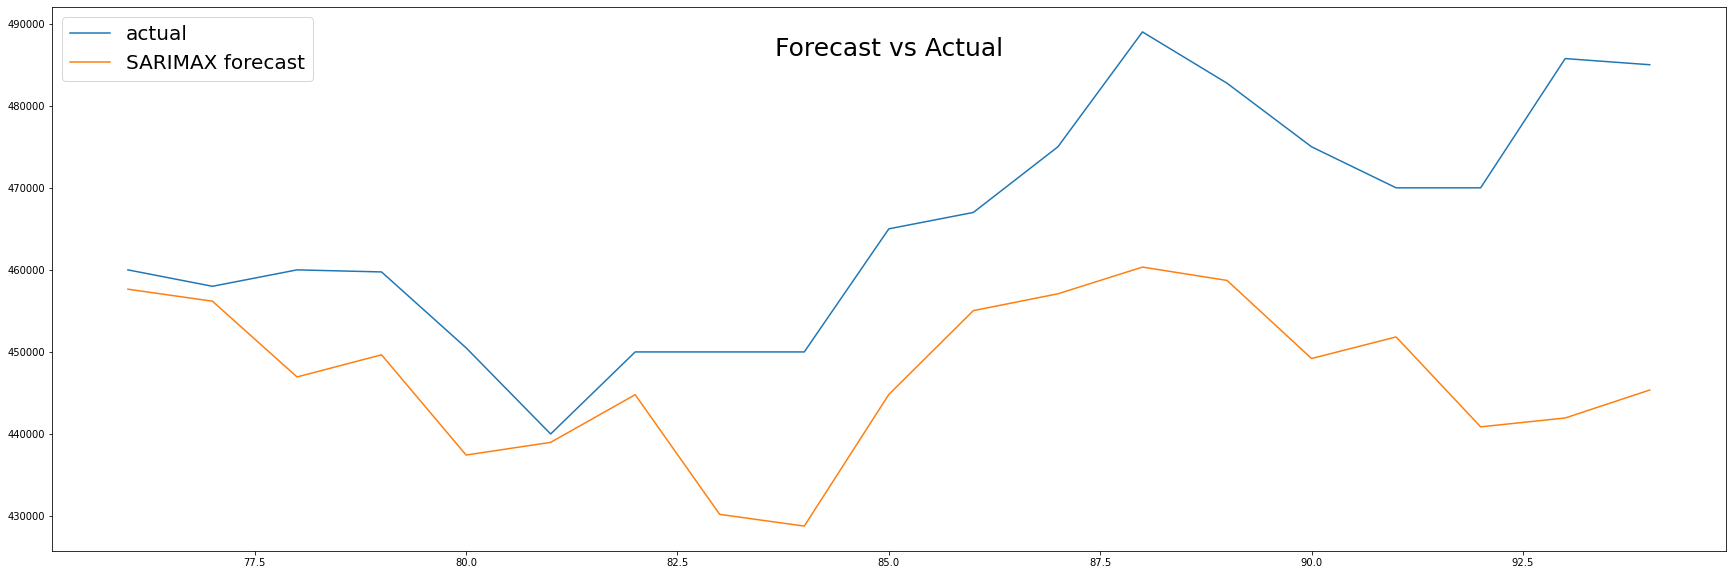

In [ ]:
y_pred_series = pd.Series(y_pred_inv,index=validation.index)
plt.figure(figsize=(30, 10))

plt.plot(validation["MedianSoldPrice"], label='actual')
plt.plot(y_pred_series, label='SARIMAX forecast')
plt.legend(loc='upper left', fontsize=20)
plt.title('Forecast vs Actual', fontsize = 25, y = 0.9)
plt.show()

In [ ]:
rmse = sqrt(mean_squared_error(validation["MedianSoldPrice"], y_pred_series))
rmse

21676.3071146976

### Candidate 7 SARIMAX Model -  Unemployment Rate as Exogenous 

In [ ]:
history_sarimax = history[['Date', 'MedianSoldPrice_AllHomes.California','MedianMortageRate','UnemploymentRate']]
history_sarimax = history_sarimax[['UnemploymentRate', 'MedianSoldPrice_AllHomes.California']]

In [ ]:
train_size = int(len(history_sarimax) * 0.8)
train, validation = history_sarimax[0:train_size], history_sarimax[train_size:]

#scale data
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range=(0, 1))

train_sc = sc.fit_transform(train)
validation_sc = sc.transform(validation)

In [9]:
#auto sarimax search with m=12
from pmdarima.arima import auto_arima
model=auto_arima(train_sc[:,-1], # MedianSoldPrice as endogenous
                 exogenous= train_sc[:,:-1], # MedianMortgage as exogenous variable
                 start_p=0, start_q=0, 
                 max_p=4, max_q=4, 
                 max_d=2,
                 trace=True,seasonal=True,D=1,m=12, max_P=3, max_Q=3, #add seasonality
                 error_action='ignore', 
                 suppress_warnings=True,information_criterion='oob', n_jobs = -1)

In [ ]:
y_pred = model.predict(n_periods=len(validation_sc),X=validation_sc[:,:-1]).reshape(-1,1)
y_pred_ = np.repeat(y_pred,2,axis=1) # duplicate the pred column x3 times to fit the scaler's shape
y_pred_inv = sc.inverse_transform(y_pred_)[:,-1] # inverset he duplicated y_pred and get the last colomn as result

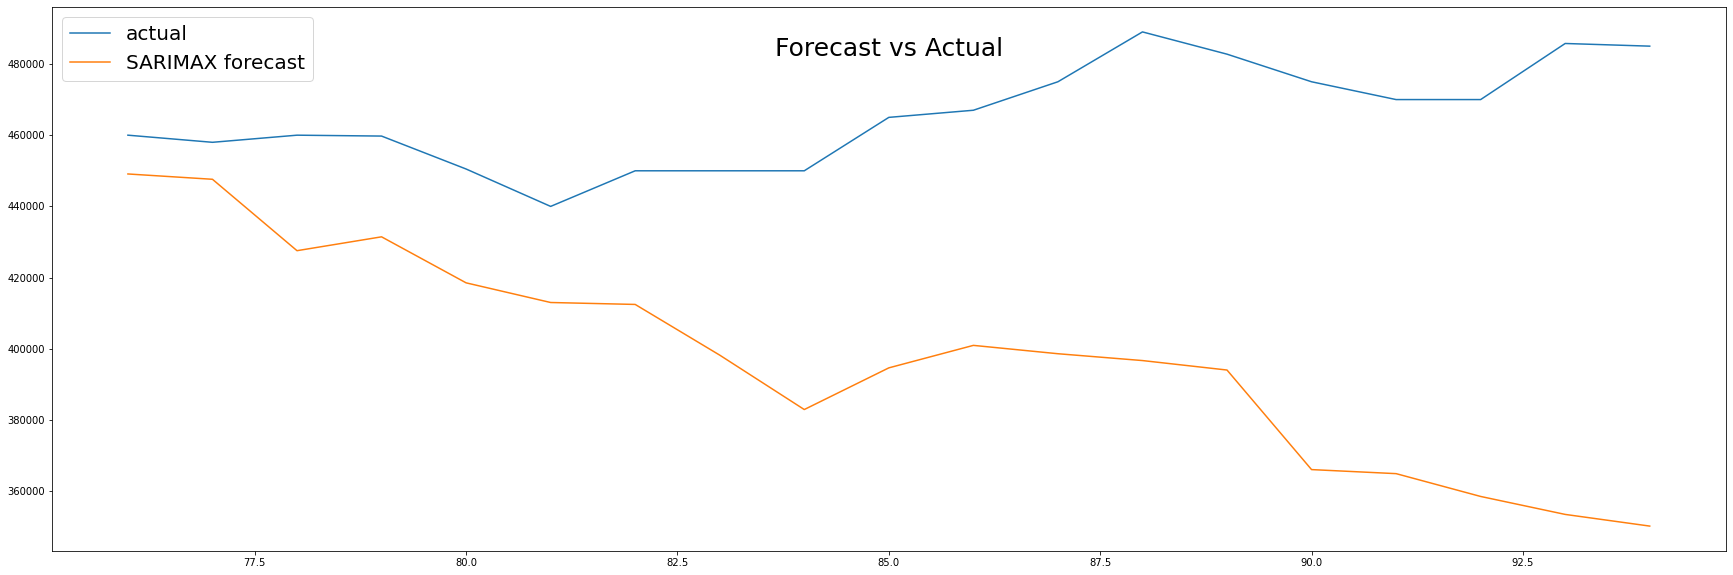

In [ ]:
y_pred_series = pd.Series(y_pred_inv,index=validation.index)
plt.figure(figsize=(30, 10))

plt.plot(validation["MedianSoldPrice_AllHomes.California"], label='actual')
plt.plot(y_pred_series, label='SARIMAX forecast')
plt.legend(loc='upper left', fontsize=20)
plt.title('Forecast vs Actual', fontsize = 25, y = 0.9)
plt.show()

In [ ]:
rmse = sqrt(mean_squared_error(validation["MedianSoldPrice_AllHomes.California"], y_pred_series))
rmse

77766.63151139136

### Candidate 8: SARIMAX Model -  Median Mortgage Rate and Unemployment Rate as Exogenous

In [ ]:
history_sarimax = history[['Date', 'MedianSoldPrice_AllHomes.California','MedianMortageRate','UnemploymentRate']]
history_sarimax = history_sarimax[['UnemploymentRate', 'MedianMortageRate' , 'MedianSoldPrice_AllHomes.California']]
history_sarimax.index = history['Date']

In [ ]:
train_size = int(len(history_sarimax) * 0.8)
train, validation = history_sarimax[0:train_size], history_sarimax[train_size:]

#scale data
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range=(0, 1))

train_sc = sc.fit_transform(train)
validation_sc = sc.transform(validation)

In [10]:
#auto sarimax search with m=12
from pmdarima.arima import auto_arima
model=auto_arima(train_sc[:,-1], # MedianSoldPrice as endogenous
                 exogenous= train_sc[:,:-1], # MedianMortgage, Unemployment as exogenous variable
                 start_p=0, start_q=0, 
                 max_p=4, max_q=4, 
                 max_d=2,
                 trace=True,seasonal=True,D=1,m=12, max_P=3, max_Q=3, #add seasonality
                 error_action='ignore', 
                 suppress_warnings=True,information_criterion='oob', n_jobs = -1)

In [ ]:
y_pred = model.predict(n_periods=len(validation_sc),X=validation_sc[:,:-1]).reshape(-1,1)
y_pred_ = np.repeat(y_pred,3,axis=1) # duplicate the pred column x3 times to fit the scaler's shape
y_pred_inv = sc.inverse_transform(y_pred_)[:,-1] # inverset he duplicated y_pred and get the last colomn as result

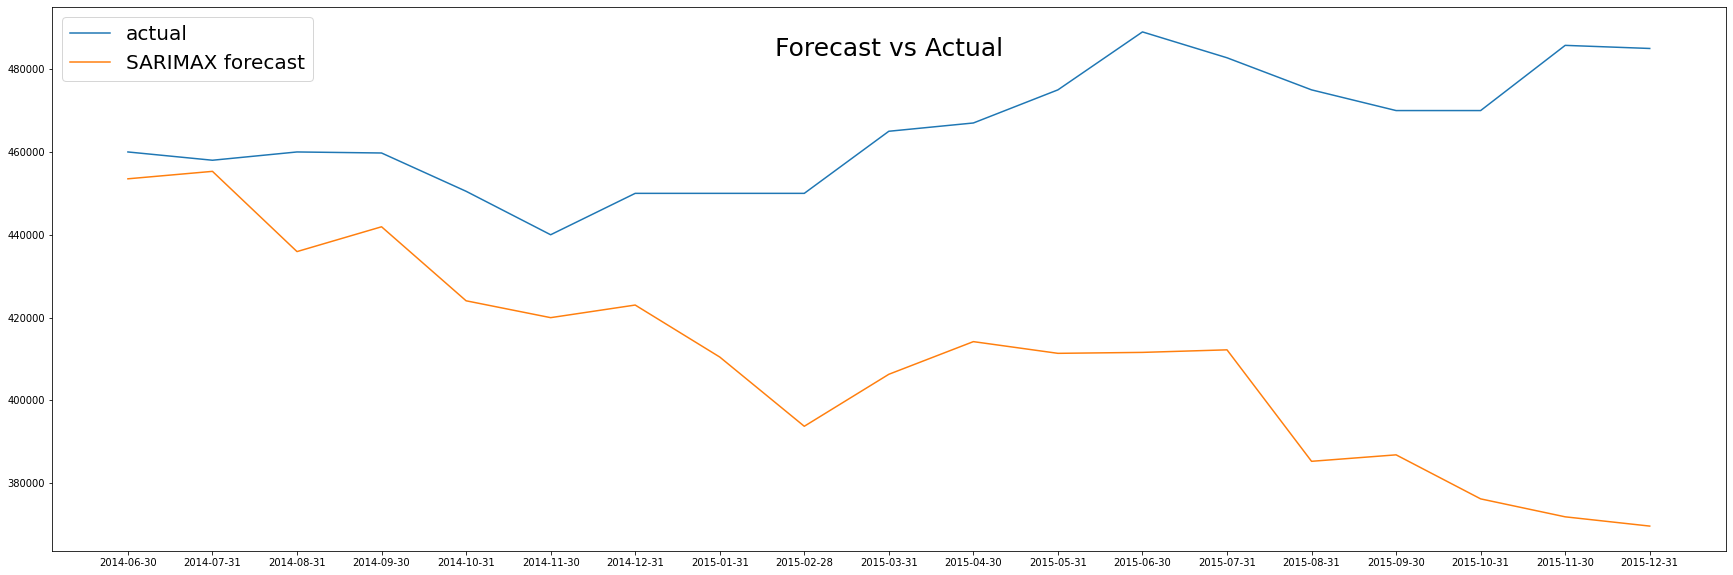

In [ ]:
y_pred_series = pd.Series(y_pred_inv,index=validation.index)
plt.figure(figsize=(30, 10))

plt.plot(validation["MedianSoldPrice_AllHomes.California"], label='actual')
plt.plot(y_pred_series, label='SARIMAX forecast')
plt.legend(loc='upper left', fontsize=20)
plt.title('SARIMAX: Unemployment and Mortgage Rates as Exogenous', fontsize = 25, y = 0.9)
plt.show()

In [ ]:
rmse = sqrt(mean_squared_error(validation["MedianSoldPrice_AllHomes.California"], y_pred_series))
rmse

64405.04182023234

### Candidate 9: LSTM

In [ ]:
history.head()

,Date,MedianSoldPrice_AllHomes.California,MedianMortageRate,UnemploymentRate
0,2008-02-29,470000.0,5.29,6.3
1,2008-03-31,441000.0,5.44,6.2
2,2008-04-30,460000.0,5.42,6.4
3,2008-05-31,429000.0,5.47,6.3
4,2008-06-30,437500.0,5.60,6.2


In [ ]:
dt = history.set_index('Date')

In [ ]:
dt.head()

,MedianSoldPrice_AllHomes.California,MedianMortageRate,UnemploymentRate
Date,,,
2008-02-29,470000.0,5.29,6.3
2008-03-31,441000.0,5.44,6.2
2008-04-30,460000.0,5.42,6.4
2008-05-31,429000.0,5.47,6.3
2008-06-30,437500.0,5.60,6.2


In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
        return agg

In [ ]:
values = dt.values
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

In [ ]:
reframed = series_to_supervised(scaled, 1, 1) 
print(reframed.head())

   var1(t-1)  var2(t-1)  var3(t-1)   var1(t)   var2(t)   var3(t)
1   0.876623   0.729927   0.317073  0.688312  0.784672  0.292683
2   0.688312   0.784672   0.292683  0.811688  0.777372  0.341463
3   0.811688   0.777372   0.341463  0.610390  0.795620  0.317073
4   0.610390   0.795620   0.317073  0.665584  0.843066  0.292683
5   0.665584   0.843066   0.292683  0.571429  0.956204  0.146341


In [ ]:
# drop column we don't want to predict, aka weather
reframed.drop(reframed.columns[[4, 5]], axis=1, inplace=True)
print(reframed.head())

   var1(t-1)  var2(t-1)  var3(t-1)   var1(t)
1   0.876623   0.729927   0.317073  0.688312
2   0.688312   0.784672   0.292683  0.811688
3   0.811688   0.777372   0.341463  0.610390
4   0.610390   0.795620   0.317073  0.665584
5   0.665584   0.843066   0.292683  0.571429


In [ ]:
history.shape

(95, 4)

In [ ]:
history.loc[data['Date']<='2015-12-31']

,Date,MedianSoldPrice_AllHomes.California,MedianMortageRate,UnemploymentRate
0,2008-02-29,470000.0,5.29,6.3
1,2008-03-31,441000.0,5.44,6.2
2,2008-04-30,460000.0,5.42,6.4
3,2008-05-31,429000.0,5.47,6.3
4,2008-06-30,437500.0,5.60,6.2
...,...,...,...,...
90,2015-08-31,475000.0,3.95,5.2
91,2015-09-30,470000.0,3.87,5.1
92,2015-10-31,470000.0,3.80,5.0
93,2015-11-30,485750.0,3.69,5.0


In [ ]:
# split into train and test sets
values = reframed.values
period=int(len(values)*0.8)
train = values[:period, :]
test = values[period:, :]

train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(75, 1, 3) (75,) (19, 1, 3) (19,)


In [ ]:
import keras
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
# design network
model = Sequential()
model.add(LSTM(3, input_shape=(train_X.shape[1], train_X.shape[2]))) 
model.add(Dense(1)) 
model.compile(loss= 'mae')


In [5]:
# fit network
history = model.fit(train_X, train_y, epochs=500, batch_size=12, validation_data=(test_X, test_y))

In [ ]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate mape
mape=(np.abs(np.array(inv_y)-np.array(inv_yhat))/np.array(inv_y)).mean()


print(mape)

0.014079984535832236


In [ ]:
#Calculate RMSE for LSTM model for using 80% split of training data

from sklearn.metrics import mean_squared_error
from math import sqrt

rmse = sqrt(mean_squared_error(np.array(inv_y), np.array(inv_yhat)))

print(rmse)

8300.341389666399


In [ ]:
#plot the forecasted values from model

# make a prediction
train_yhat = model.predict(train_X)
train_X = train_X.reshape((train_X.shape[0], train_X.shape[2]))
# invert scaling for forecast
inv_train_yhat = concatenate((train_yhat, train_X[:, 1:]), axis=1)
inv_train_yhat = scaler.inverse_transform(inv_train_yhat)
inv_train_yhat = inv_train_yhat[:,0]
# invert scaling for actual
train_y = train_y.reshape((len(train_y), 1))
inv_train_y = concatenate((train_y, train_X[:, 1:]), axis=1)
inv_train_y = scaler.inverse_transform(inv_train_y)
inv_train_y = inv_train_y[:,0]

In [ ]:
print(inv_yhat.shape)
print(inv_train_yhat.shape)
print(np.concatenate((inv_train_yhat, inv_yhat), axis = 0).shape)

(19,)
(75,)
(94,)


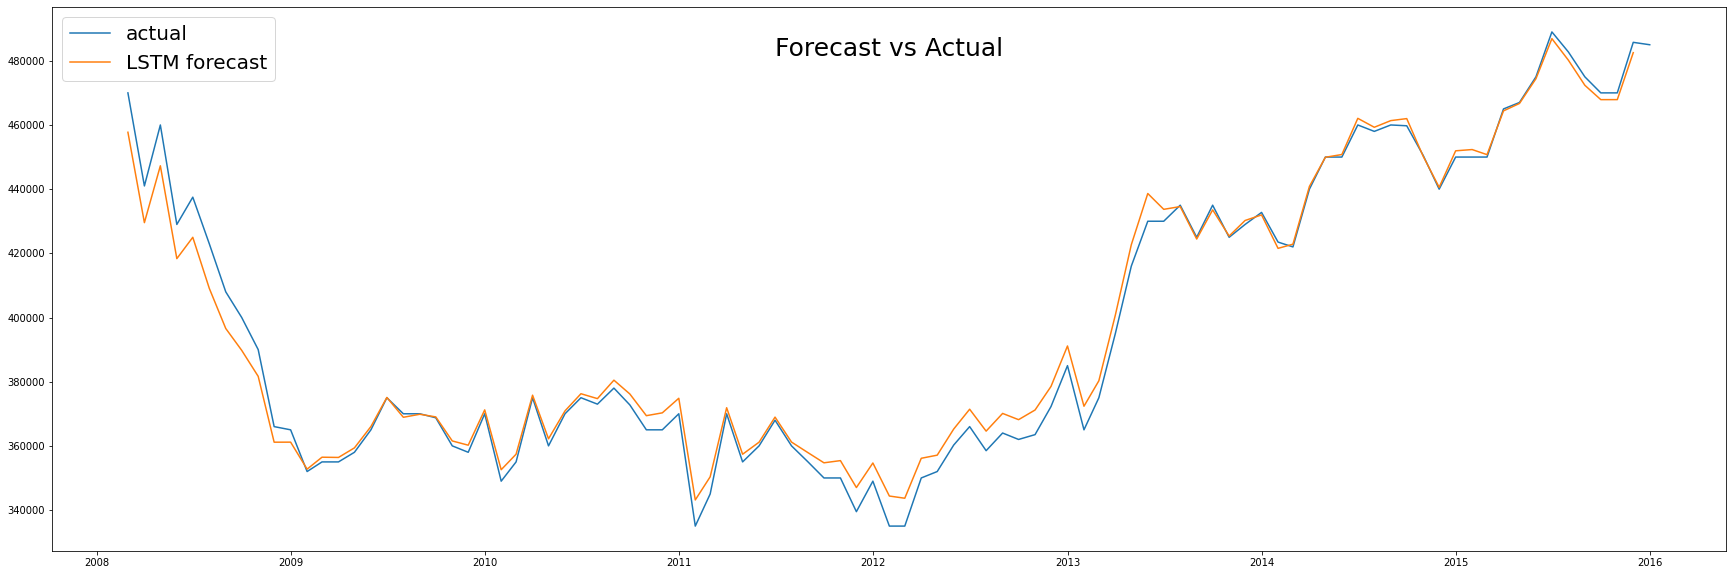

In [ ]:

plt.figure(figsize=(30, 10))

y_pred_lstm = np.concatenate((inv_train_yhat, inv_yhat), axis = 0)

plt.plot(dt.index, dt['MedianSoldPrice_AllHomes.California'], label='actual')
plt.plot(list(dt.index)[:-1], y_pred_lstm , label='LSTM forecast')
plt.legend(loc='upper left', fontsize=20)
plt.title('Forecast vs Actual', fontsize = 25, y = 0.9)
plt.show()

In [ ]:
data = pd.read_csv('zillow-carlifornia.csv').set_index('Date')
test_data = pd.read_csv('test.csv').set_index('Month')

In [ ]:
history = data[['MedianSoldPrice_AllHomes.California','MedianMortageRate', 'UnemploymentRate']].dropna()
history

,MedianSoldPrice_AllHomes.California,MedianMortageRate,UnemploymentRate
Date,,,
2008-02-29,470000.0,5.29,6.3
2008-03-31,441000.0,5.44,6.2
2008-04-30,460000.0,5.42,6.4
2008-05-31,429000.0,5.47,6.3
2008-06-30,437500.0,5.60,6.2
...,...,...,...
2015-08-31,475000.0,3.95,5.2
2015-09-30,470000.0,3.87,5.1
2015-10-31,470000.0,3.80,5.0


In [ ]:
test_dup = data.merge(test_data, left_index= True, right_index= True).drop(columns = ['MedianSoldPrice_AllHomes.California']).loc['2015-12-31':]
test = test_dup[['Median House Price', 'MedianMortageRate', 'UnemploymentRate']]

In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
        return agg

In [ ]:
train_values = history.values
test_values = test.values

# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_train = scaler.fit_transform(train_values)
scaled_test = scaler.fit_transform(test_values)

In [ ]:
reframed_train = series_to_supervised(scaled_train, 1, 1) 
reframed_test = series_to_supervised(scaled_test, 1, 1) 
print(reframed_train.head())

   var1(t-1)  var2(t-1)  var3(t-1)   var1(t)   var2(t)   var3(t)
1   0.876623   0.729927   0.317073  0.688312  0.784672  0.292683
2   0.688312   0.784672   0.292683  0.811688  0.777372  0.341463
3   0.811688   0.777372   0.341463  0.610390  0.795620  0.317073
4   0.610390   0.795620   0.317073  0.665584  0.843066  0.292683
5   0.665584   0.843066   0.292683  0.571429  0.956204  0.146341


In [ ]:
# drop column we don't want to predict
reframed_train.drop(reframed_train.columns[[4, 5]], axis=1, inplace=True)
reframed_test.drop(reframed_test.columns[[4, 5]], axis=1, inplace=True)
print(reframed_train.head())

   var1(t-1)  var2(t-1)  var3(t-1)   var1(t)
1   0.876623   0.729927   0.317073  0.688312
2   0.688312   0.784672   0.292683  0.811688
3   0.811688   0.777372   0.341463  0.610390
4   0.610390   0.795620   0.317073  0.665584
5   0.665584   0.843066   0.292683  0.571429


In [ ]:
# split into input and outputs
train_X, train_y = reframed_train.values[:, :-1], reframed_train.values[:, -1]
test_X, test_y = reframed_test.values[:, :-1], reframed_test.values[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(94, 1, 3) (94,) (11, 1, 3) (11,)


In [ ]:
import keras
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
# design network
model = Sequential()
model.add(LSTM(3, input_shape=(train_X.shape[1], train_X.shape[2]))) # the 3 is the number of hidden layers/neurons, proportional to the sample size
model.add(Dense(1)) #final fully-connected (dense) layer, optional
model.compile(loss= 'mae')


In [8]:
# fit network
history = model.fit(train_X, train_y, epochs=500, batch_size=12)
#The model will be fit for 500 training epochs with a batch size of 12(since this is monthly data). 
#Remember that the internal state of the LSTM in Keras is reset at the end of each batch, so an internal state that is a function of a number of days may be helpful.

In [ ]:
test_X.shape

(11, 1, 3)

In [ ]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))

inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

mape=(np.abs(np.array(inv_y)-np.array(inv_yhat))/np.array(inv_y)).mean()

print(mape)

0.016065030039089188


In [ ]:
#Calculate RMSE for LSTM model for given test data

from sklearn.metrics import mean_squared_error
from math import sqrt

rmse = sqrt(mean_squared_error(np.array(inv_y), np.array(inv_yhat)))

print(" RMSE of Final Model using LSTM is : ", rmse)

 RMSE of Final Model using LSTM is :  10338.497889013888


In [ ]:
#plot the forecasted values from model

# make a prediction
train_yhat = model.predict(train_X)
train_X = train_X.reshape((train_X.shape[0], train_X.shape[2]))

# invert scaling for forecast
inv_train_yhat = concatenate((train_yhat, train_X[:, 1:]), axis=1)
inv_train_yhat = scaler.inverse_transform(inv_train_yhat)
inv_train_yhat = inv_train_yhat[:,0]

In [ ]:
history = data[['MedianSoldPrice_AllHomes.California','MedianMortageRate', 'UnemploymentRate']].dropna()

test_dup = data.merge(test_data, left_index= True, right_index= True).drop(columns = ['MedianSoldPrice_AllHomes.California']).loc['2015-12-31':]
test = test_dup[['Median House Price', 'MedianMortageRate', 'UnemploymentRate']]

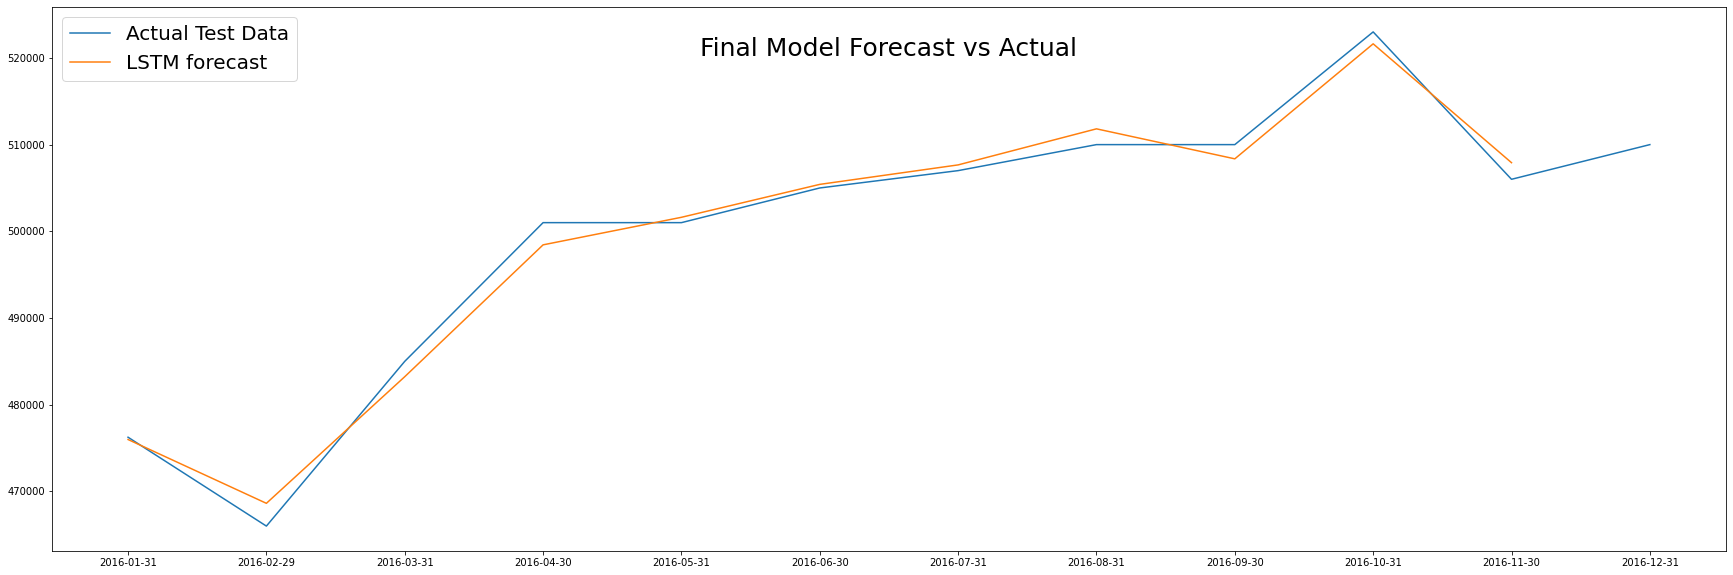

In [ ]:

plt.figure(figsize=(30, 10))

plt.plot(test.index, test['Median House Price'], label='Actual Test Data')
plt.plot(list(test.index)[:-1], inv_yhat , label='LSTM forecast')
plt.legend(loc='upper left', fontsize=20)
plt.title('Final Model Forecast vs Actual', fontsize = 25, y = 0.9)
plt.show()

In [ ]:
t = pd.DataFrame(data = {'Forecasted Median Prices': inv_yhat, 'Actual Median Prices': test['Median House Price'].iloc[:-1]} )

In [ ]:
t

,Forecasted Median Prices,Actual Median Prices
2016-01-31,475986.445040,476250
2016-02-29,468626.511414,466000
2016-03-31,483230.200022,485000
2016-04-30,498438.976467,501000
2016-05-31,501616.710186,501000
2016-06-30,505414.341927,505000
2016-07-31,507660.174847,507000
2016-08-31,511820.146203,510000
2016-09-30,508360.426307,510000
2016-10-31,521626.021087,523000


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=bd2abfc2-703e-4c6c-9e1f-df541620896e' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>